In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, Concatenate, UpSampling2D, BatchNormalization, Activation, Conv2DTranspose, Add, MaxPool2D, ZeroPadding2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import gc


In [7]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, SpatialDropout2D


In [8]:
# Read and examine metadata
#raw_data = pd.read_csv(r"/content/drive/MyDrive/COVID-19 Lung CT Scan Segmentation/metadata_COLAB.csv")
raw_data = pd.read_csv(r"../COVID-19 Lung CT Scan Segmentation/COVID-19 Lung CT Scan Segmentation/metadata_temp.csv")
raw_data.sample(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
12,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
5,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
2,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
11,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
14,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...


In [9]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [10]:
# Read sample
sample_ct   = read_nii(raw_data.loc[1,'ct_scan'])
sample_lung = read_nii(raw_data.loc[1,'lung_mask'])
sample_infe = read_nii(raw_data.loc[1,'infection_mask'])
sample_all  = read_nii(raw_data.loc[1,'lung_and_infection_mask'])

# Examine Shape
sample_ct.shape

(512, 512, 200)

Text(0.5, 1.0, 'Lung and Infection Mask')

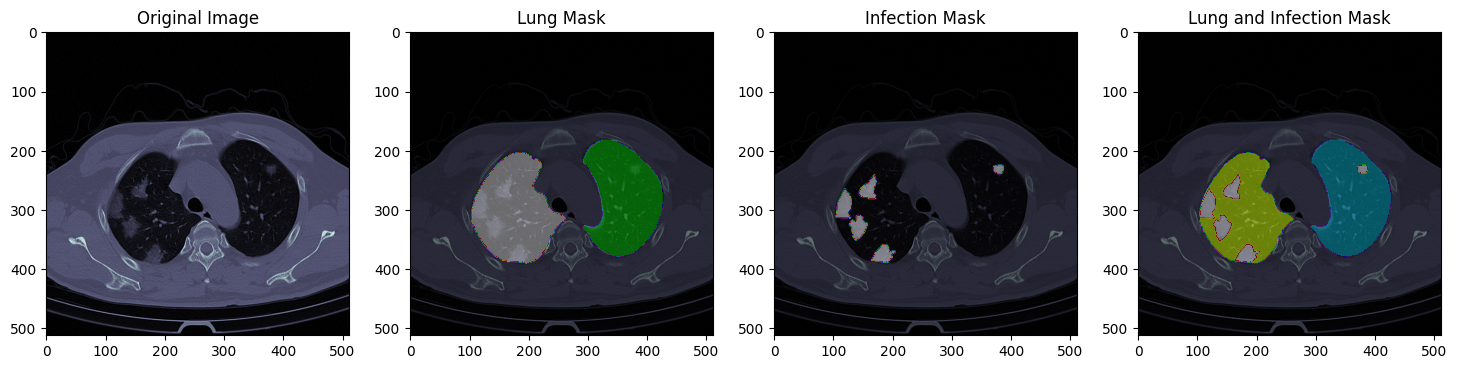

In [11]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_lung[..., 150],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')

plt.subplot(1,4,3)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_infe[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_all[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask')

In [12]:
IMG_SIZE = 128
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH = IMG_SIZE
IMG_CHANNELS = 1

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def get_data():
    lungs_data = []
    infections_data  = []

    for row in range(len(raw_data)):
        lungs_image = read_nii(raw_data['ct_scan'][row])
        infection_image = read_nii(raw_data['infection_mask'][row])

        for slice_no in range(lungs_image.shape[2]):
            lung_slice = cv2.resize(lungs_image[..., slice_no], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
            infection_slice = cv2.resize(infection_image[..., slice_no], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')

            lung_slice_temp = lung_slice.reshape(-1, 2)
            lung_slice_temp = scaler.fit_transform(lung_slice_temp)
            lung_slice = lung_slice_temp.reshape(lung_slice.shape)
            lungs_data.append(lung_slice[..., np.newaxis])

            infections_data.append(infection_slice[..., np.newaxis])
    return lungs_data, infections_data

In [14]:
data = get_data()
lungs = np.array(data[0])
infections = np.array(data[1])

Text(0.5, 1.0, 'Transformed Infection Mask')

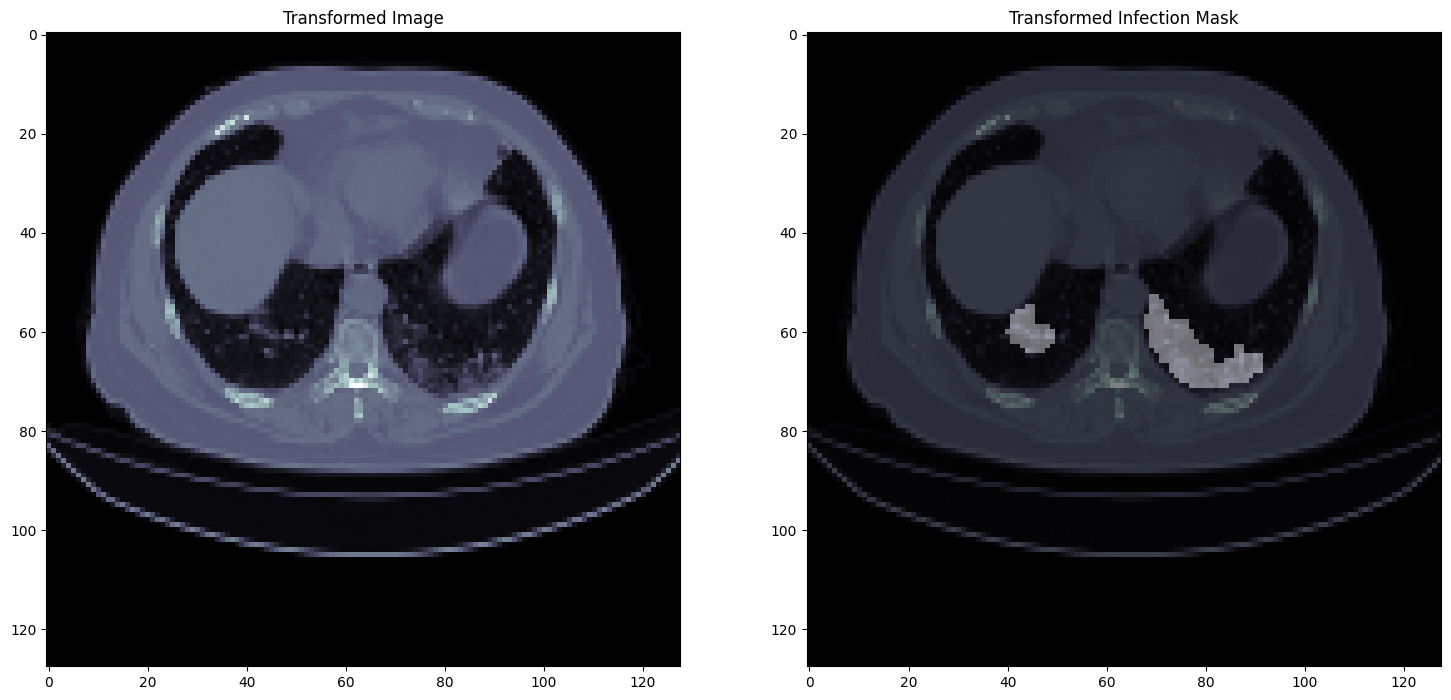

In [15]:
num = 101
fig = plt.figure(figsize = (18,15))
plt.subplot(1,2,1)
plt.imshow(lungs[num], cmap = 'bone')
plt.title('Transformed Image')

plt.subplot(1,2,2)
plt.imshow(lungs[num], cmap = 'bone')
plt.imshow(infections[num],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Transformed Infection Mask')

In [16]:
# Split the data into train and test sets
lung_train, lung_test, infect_train, infect_test = train_test_split(lungs, infections, test_size=0.1, shuffle=True)

In [17]:
lung_train.shape, lung_test.shape, infect_train.shape, infect_test.shape

((3168, 128, 128, 1),
 (352, 128, 128, 1),
 (3168, 128, 128, 1),
 (352, 128, 128, 1))

In [18]:
def conv_block(inputs, out_ch, rate=1):
    x = Conv2D(out_ch, 3, padding="same", dilation_rate=1)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def RSU_L(inputs, out_ch, int_ch, num_layers, rate=2):
    """ Initial Conv """
    x = conv_block(inputs, out_ch)
    init_feats = x

    """ Encoder """
    skip = []
    x = conv_block(x, int_ch)
    skip.append(x)

    for i in range(num_layers-2):
        x = MaxPool2D((2, 2))(x)
        x = conv_block(x, int_ch)
        skip.append(x)

    """ Bridge """
    x = conv_block(x, int_ch, rate=rate)

    """ Decoder """
    skip.reverse()

    x = Concatenate()([x, skip[0]])
    x = conv_block(x, int_ch)

    for i in range(num_layers-3):
        x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
        x = Concatenate()([x, skip[i+1]])
        x = conv_block(x, int_ch)

    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = Concatenate()([x, skip[-1]])
    x = conv_block(x, out_ch)

    """ Add """
    x = Add()([x, init_feats])
    return x

def RSU_4F(inputs, out_ch, int_ch):
    """ Initial Conv """
    x0 = conv_block(inputs, out_ch, rate=1)

    """ Encoder """
    x1 = conv_block(x0, int_ch, rate=1)
    x2 = conv_block(x1, int_ch, rate=2)
    x3 = conv_block(x2, int_ch, rate=4)

    """ Bridge """
    x4 = conv_block(x3, int_ch, rate=8)

    """ Decoder """
    x = Concatenate()([x4, x3])
    x = conv_block(x, int_ch, rate=4)

    x = Concatenate()([x, x2])
    x = conv_block(x, int_ch, rate=2)

    x = Concatenate()([x, x1])
    x = conv_block(x, out_ch, rate=1)

    """ Addition """
    x = Add()([x, x0])
    return x

def u2net(input_shape, out_ch, int_ch, num_classes=1):
    """ Input Layer """
    inputs = Input(input_shape)
    s0 = inputs

    """ Encoder """
    s1 = RSU_L(s0, out_ch[0], int_ch[0], 7)
    p1 = MaxPool2D((2, 2))(s1)

    s2 = RSU_L(p1, out_ch[1], int_ch[1], 6)
    p2 = MaxPool2D((2, 2))(s2)

    s3 = RSU_L(p2, out_ch[2], int_ch[2], 5)
    p3 = MaxPool2D((2, 2))(s3)

    s4 = RSU_L(p3, out_ch[3], int_ch[3], 4)
    p4 = MaxPool2D((2, 2))(s4)

    s5 = RSU_4F(p4, out_ch[4], int_ch[4])
    p5 = MaxPool2D((2, 2))(s5)

    """ Bridge """
    b1 = RSU_4F(p5, out_ch[5], int_ch[5])
    b2 = UpSampling2D(size=(2, 2), interpolation="bilinear")(b1)

    """ Decoder """
    d1 = Concatenate()([b2, s5])
    d1 = RSU_4F(d1, out_ch[6], int_ch[6])
    u1 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d1)

    d2 = Concatenate()([u1, s4])
    d2 = RSU_L(d2, out_ch[7], int_ch[7], 4)
    u2 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d2)

    d3 = Concatenate()([u2, s3])
    d3 = RSU_L(d3, out_ch[8], int_ch[8], 5)
    u3 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d3)

    d4 = Concatenate()([u3, s2])
    d4 = RSU_L(d4, out_ch[9], int_ch[9], 6)
    u4 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d4)

    d5 = Concatenate()([u4, s1])
    d5 = RSU_L(d5, out_ch[10], int_ch[10], 7)

    """ Side Outputs """
    y1 = Conv2D(num_classes, 3, padding="same")(d5)

    y2 = Conv2D(num_classes, 3, padding="same")(d4)
    y2 = UpSampling2D(size=(2, 2), interpolation="bilinear")(y2)

    y3 = Conv2D(num_classes, 3, padding="same")(d3)
    y3 = UpSampling2D(size=(4, 4), interpolation="bilinear")(y3)

    y4 = Conv2D(num_classes, 3, padding="same")(d2)
    y4 = UpSampling2D(size=(8, 8), interpolation="bilinear")(y4)

    y5 = Conv2D(num_classes, 3, padding="same")(d1)
    y5 = UpSampling2D(size=(16, 16), interpolation="bilinear")(y5)

    y6 = Conv2D(num_classes, 3, padding="same")(b1)
    y6 = UpSampling2D(size=(32, 32), interpolation="bilinear")(y6)

    y0 = Concatenate()([y1, y2, y3, y4, y5, y6])
    y0 = Conv2D(num_classes, 3, padding="same")(y0)

    y0 = Activation("sigmoid")(y0)
    y1 = Activation("sigmoid")(y1)
    y2 = Activation("sigmoid")(y2)
    y3 = Activation("sigmoid")(y3)
    y4 = Activation("sigmoid")(y4)
    y5 = Activation("sigmoid")(y5)
    y6 = Activation("sigmoid")(y6)

    model = tf.keras.models.Model(inputs, outputs=tf.reduce_mean([y0, y1, y2, y3, y4, y5, y6], axis=0))
    return model

def build_u2net(input_shape, num_classes=1):
    out_ch = [64, 128, 256, 512, 512, 512, 512, 256, 128, 64, 64]
    int_ch = [32, 32, 64, 128, 256, 256, 256, 128, 64, 32, 16]
    model = u2net(input_shape, out_ch, int_ch, num_classes=num_classes)
    return model

def build_u2net_lite(input_shape, num_classes=1):
    out_ch = [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
    int_ch = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
    model = u2net(input_shape, out_ch, int_ch, num_classes=num_classes)
    return model

In [19]:
if __name__ == "__main__":
    model = build_u2net_lite((128, 128, 1))
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [20]:
import tensorflow.keras.backend as K

def jaccard_loss(y_true, y_pred, smooth=1e-7):
    y_true = K.cast(y_true, dtype='float32')  # Cast y_true to float32
    intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
    union = K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3)) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return 1 - jaccard

In [21]:
from keras import backend as K
K.clear_session()
metrics = ["accuracy",
           tf.keras.metrics.AUC(),
           tf.keras.metrics.SensitivityAtSpecificity(0.5),
           tf.keras.metrics.SpecificityAtSensitivity(0.5),
           tf.keras.metrics.MeanIoU(num_classes=2)]  # Use MeanIoU as the Jaccard Index metric
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)  # Use custom Jaccard loss

gc.collect()

2057

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)


(process:14236): GLib-GIO-WARNING **: 22:39:42.722: Unexpectedly, UWP app `18184wherewhere.AndroidAppInstaller_0.1.25.0_x64__4v4sx105x6y4r' (AUMId `18184wherewhere.AndroidAppInstaller_4v4sx105x6y4r!App') supports 4 extensions but has no verbs

(process:14236): GLib-GIO-WARNING **: 22:39:43.125: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2310.54.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs

(process:14236): GLib-GIO-WARNING **: 22:39:43.153: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.8.3.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.494611 to fit

(process:14236): GLib-GIO-WARNING **: 22:39:43.276: Unexpectedly, UWP app `Microsoft.OutlookForWindows_1.2023.1214.201_x64__8wekyb3d8bbwe' (AUMId `Microsoft.OutlookForWindows_8wekyb3d8bbwe!Microsoft.OutlookforWindows') supports 1 extensi

In [24]:
# Define callbacks
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('Usquared_JB.h5', verbose=1, save_best_only=True, save_weights_only=True),
]


In [25]:
results = model.fit(lung_train, infect_train, batch_size=8, epochs=50, callbacks=callbacks, validation_data=(lung_test, infect_test), use_multiprocessing=True)

Epoch 1/50


KeyboardInterrupt: 

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,mean_io_u,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,val_mean_io_u,lr
25,0.004645,0.998545,0.999401,0.999325,0.999940,0.496705,0.005306,0.998276,0.996714,0.994202,0.999875,0.49668,0.00001
22,0.004771,0.998472,0.999282,0.999141,0.999938,0.496705,0.005307,0.998261,0.997000,0.994777,0.999889,0.49668,0.00010
24,0.004656,0.998534,0.999393,0.999313,0.999940,0.496705,0.005307,0.998274,0.996662,0.994098,0.999876,0.49668,0.00001
30,0.004609,0.998560,0.999427,0.999366,0.999939,0.496705,0.005309,0.998278,0.996545,0.993863,0.999870,0.49668,0.00001
21,0.004818,0.998445,0.999248,0.999091,0.999938,0.496705,0.005311,0.998256,0.997212,0.995221,0.999881,0.49668,0.00010
27,0.004630,0.998548,0.999376,0.999269,0.999940,0.496705,0.005311,0.998270,0.996611,0.993994,0.999876,0.49668,0.00001
26,0.004629,0.998551,0.999405,0.999328,0.999940,0.496705,0.005312,0.998271,0.996611,0.993994,0.999877,0.49668,0.00001
28,0.004624,0.998553,0.999403,0.999322,0.999939,0.496705,0.005314,0.998278,0.996558,0.993889,0.999872,0.49668,0.00001
29,0.004615,0.998559,0.999387,0.999287,0.999939,0.496705,0.005315,0.998278,0.996520,0.993811,0.999874,0.49668,0.00001
20,0.004871,0.998417,0.999238,0.999094,0.999941,0.496705,0.005320,0.998249,0.997317,0.995430,0.999891,0.49668,0.00010


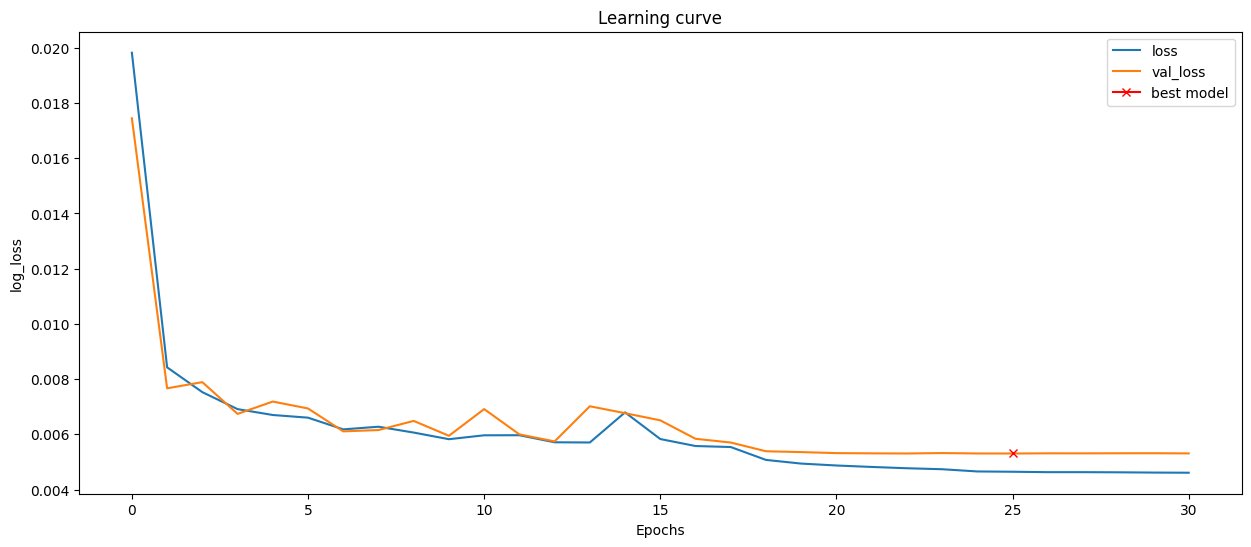

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

# plt.figure(figsize = (15,6))
# plt.title("Learning curve")
# plt.plot(results.history["accuracy"], label="Accuracy")
# plt.plot(results.history["val_accuracy"], label="val_Accuracy")
# plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend();


In [ ]:
model.save("UNet_Squared_om.h5")

In [ ]:
model = tf.keras.models.load_model("UNet_Squared_om.h5", compile=False)
model.compile()

In [ ]:
device = "CPU:0"

In [ ]:
with tf.device(device):
    # Calculate metrics
    predicted = model.predict(lung_test)

    # Flatten the predicted and true masks
    predicted_flat = np.round(np.array(predicted).flatten())
    infect_test_flat = np.array(infect_test).flatten()

In [ ]:
with tf.device(device):
    # Calculate metrics for training data
    train_predicted = model.predict(lung_train)

    # Calculate metrics for testing data
    test_predicted = model.predict(lung_test)

In [ ]:
np.array(train_predicted).shape, infect_train.shape

((3168, 128, 128, 1), (3168, 128, 128, 1))

In [ ]:
with tf.device(device):
    # Flatten the predicted and true masks
    train_predicted_flat = np.round(np.array(train_predicted).flatten())
    infect_train_flat = np.array(infect_train).flatten()

    # Calculate precision and recall for training data
    train_precision = Precision()
    train_recall = Recall()
    train_precision.update_state(infect_train_flat, train_predicted_flat)
    train_recall.update_state(infect_train_flat, train_predicted_flat)

    # Calculate F1 score for training data
    train_f1_score = 2 * (train_precision.result() * train_recall.result()) / (train_precision.result() + train_recall.result())

    # Calculate accuracy for training data
    train_accuracy = np.mean(train_predicted_flat == infect_train_flat)


    # Flatten the predicted and true masks for testing data
    test_predicted_flat = np.round(np.array(test_predicted).flatten())
    infect_test_flat = np.array(infect_test).flatten()

    # Calculate precision and recall for testing data
    test_precision = Precision()
    test_recall = Recall()
    test_precision.update_state(infect_test_flat, test_predicted_flat)
    test_recall.update_state(infect_test_flat, test_predicted_flat)

    # Calculate F1 score for testing data
    test_f1_score = 2 * (test_precision.result() * test_recall.result()) / (test_precision.result() + test_recall.result())

    # Calculate accuracy for testing data
    test_accuracy = np.mean(test_predicted_flat == infect_test_flat)

    # Calculate parameters
    total_parameters = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])

    # Calculate FLOPs
    # flops = get_flops(model, batch_size=1)  # Assuming batch_size = 1

    # Print the metrics for training data
    print("Training Metrics:")
    print("Precision: ", train_precision.result().numpy())
    print("Recall: ", train_recall.result().numpy())
    print("F1 Score: ", train_f1_score.numpy())
    print("Accuracy: ", train_accuracy)

    # Print the metrics for testing data
    print("\nTesting Metrics:")
    print("Precision: ", test_precision.result().numpy())
    print("Recall: ", test_recall.result().numpy())
    print("F1 Score: ", test_f1_score.numpy())
    print("Accuracy: ", test_accuracy)

    # Print the other metrics
    print("\nTotal Parameters: ", total_parameters)
    # print("FLOPs: ", flops)

Training Metrics:
Precision:  0.9140316
Recall:  0.8675728
F1 Score:  0.89019644
Accuracy:  0.9985895638514046

Testing Metrics:
Precision:  0.88924265
Recall:  0.8460253
F1 Score:  0.8670958
Accuracy:  0.9982780109752308

Total Parameters:  1130077


In [ ]:
with tf.device(device):
    # Calculate Jaccard Index (MeanIoU) for training data
    train_iou = tf.keras.metrics.MeanIoU(num_classes=2)
    train_iou.update_state(infect_train_flat, train_predicted_flat)
    train_mean_iou = train_iou.result().numpy()

    # Calculate Jaccard Index (MeanIoU) for testing data
    test_iou = tf.keras.metrics.MeanIoU(num_classes=2)
    test_iou.update_state(infect_test_flat, test_predicted_flat)
    test_mean_iou = test_iou.result().numpy()

    # Print the Jaccard Index (MeanIoU) for training and testing data
    print("Training Jaccard Index (MeanIoU): ", train_mean_iou)
    print("Testing Jaccard Index (MeanIoU): ", test_mean_iou)


Training Jaccard Index (MeanIoU):  0.8690963
Testing Jaccard Index (MeanIoU):  0.87477064


In [ ]:
# # Plot accuracy
# plt.plot(results.history['accuracy'])
# plt.plot(results.history['val_accuracy'])
# plt.title('Accuracy vs Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.show()

# Plot loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

NameError: name 'results' is not defined

In [ ]:
with tf.device(device):
    # Make predictions
    predicted = model.predict(lung_test)

C:\Users\kaush\AppData\Local\Temp\ipykernel_8980\1742231354.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(25, 75))


IndexError: index 128 is out of bounds for axis 0 with size 128

Error in callback <function _draw_all_if_interactive at 0x0000017CD7F8CC10> (for post_execute):


KeyboardInterrupt: 

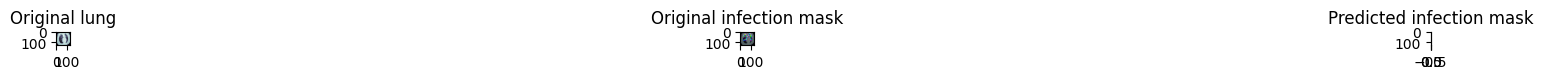

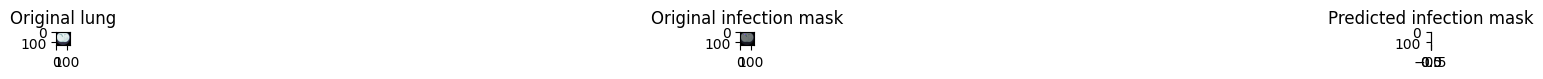

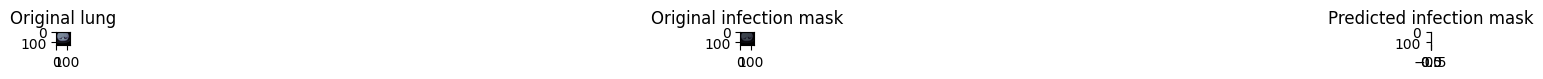

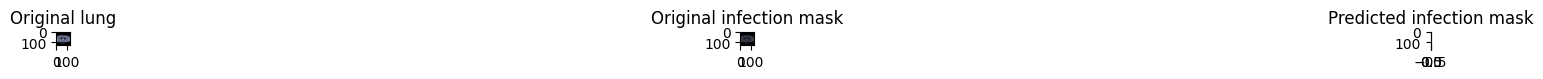

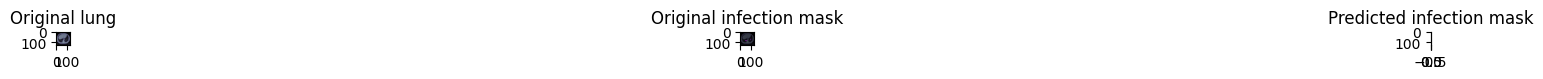

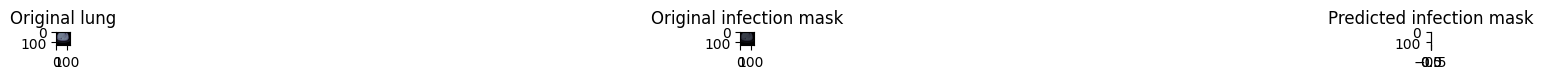

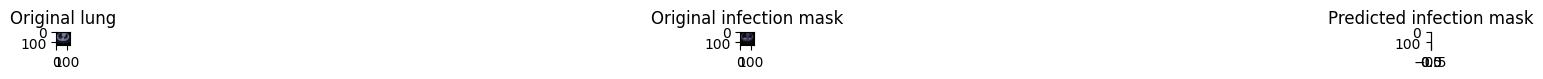

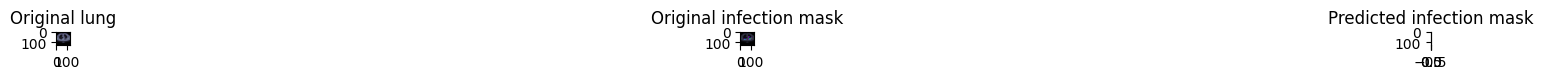

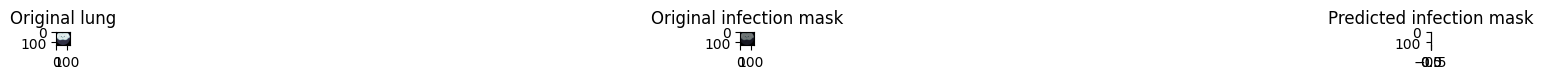

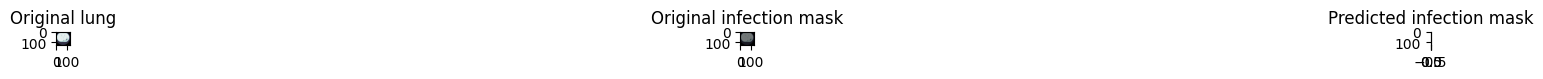

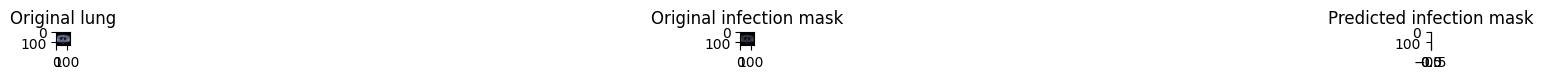

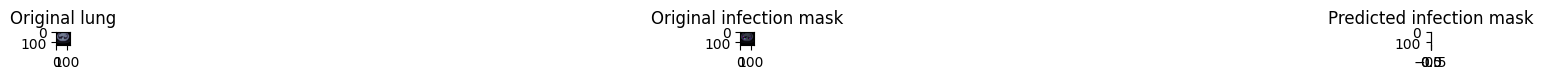

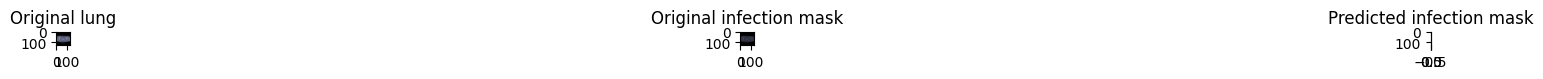

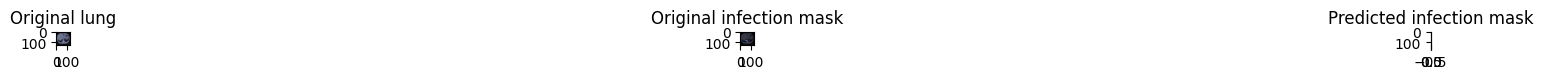

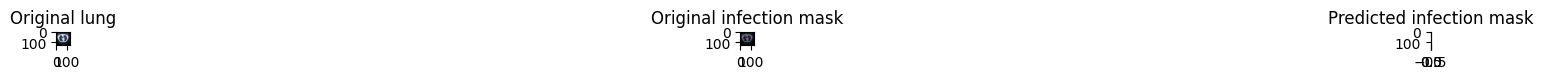

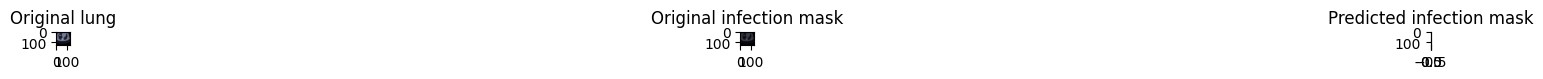

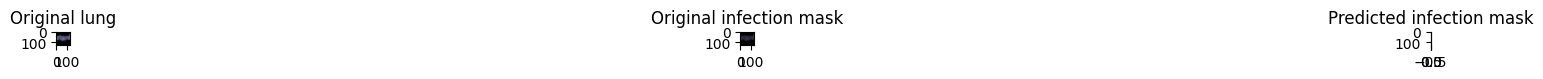

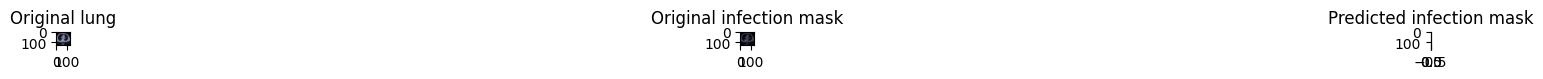

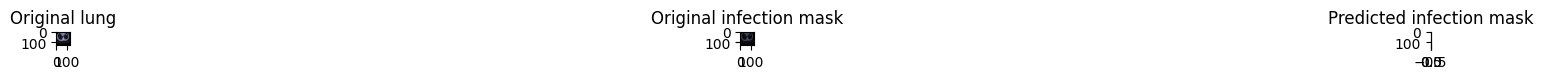

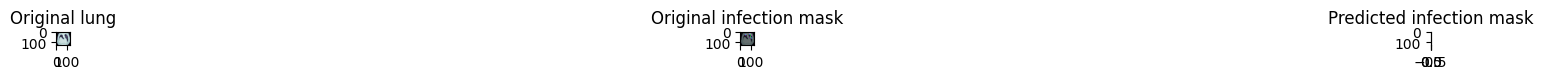

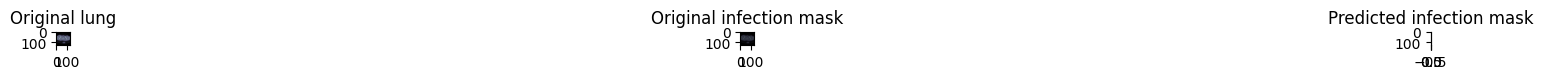

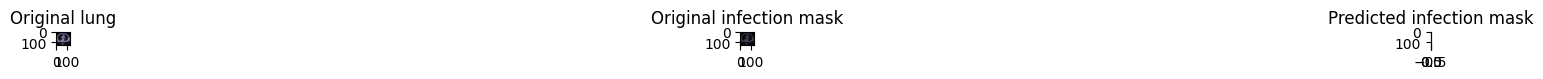

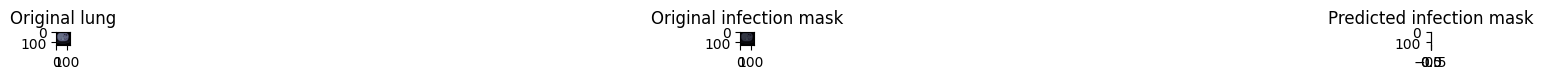

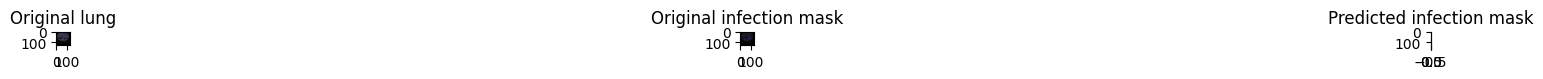

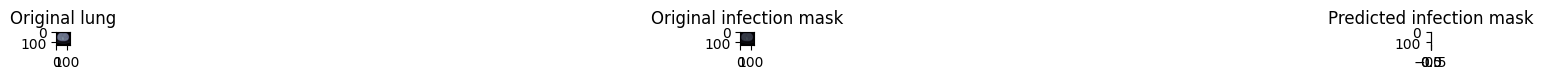

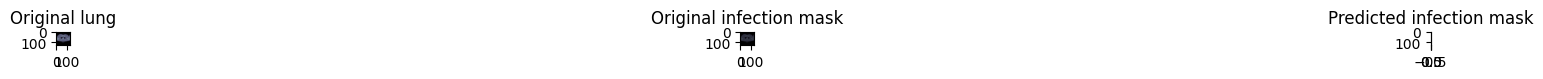

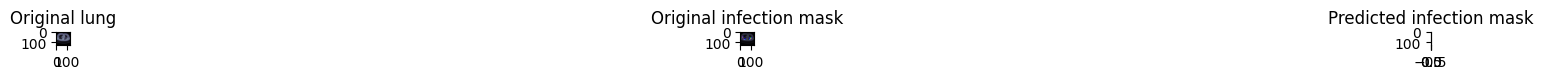

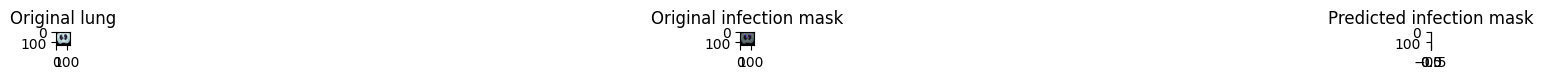

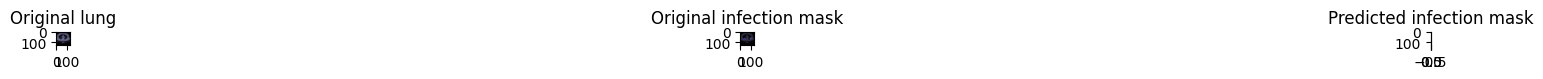

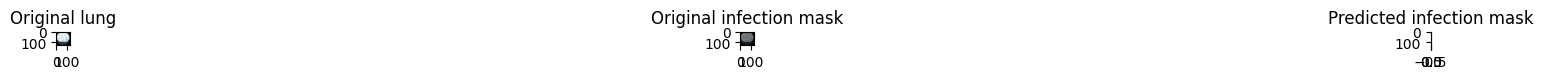

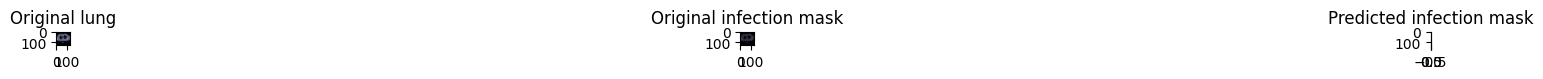

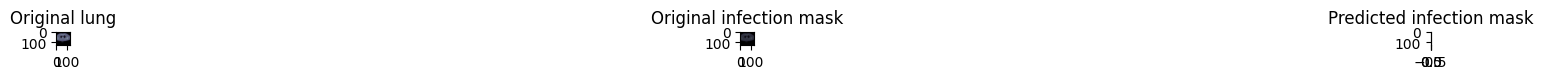

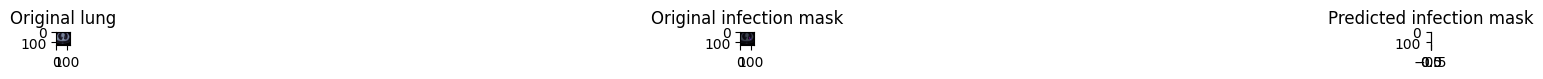

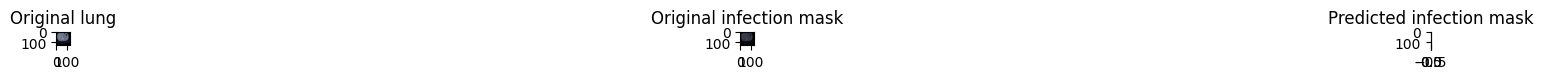

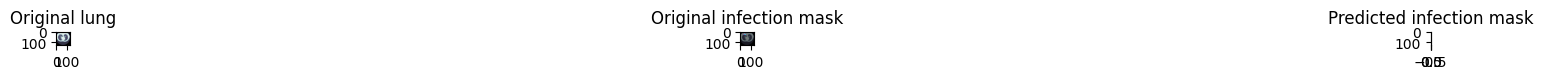

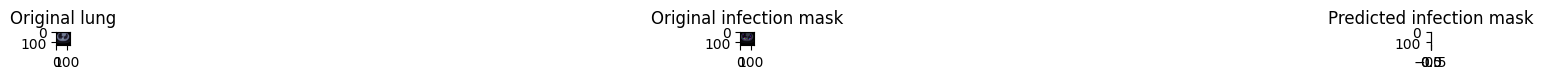

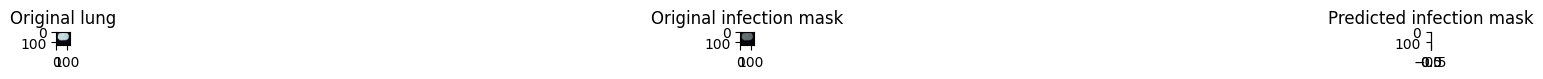

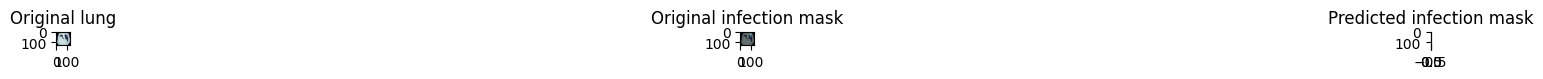

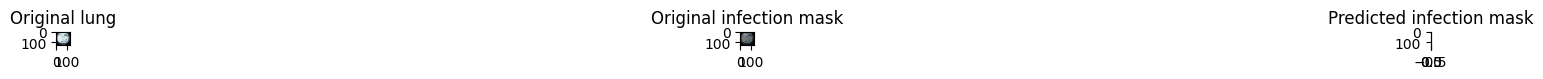

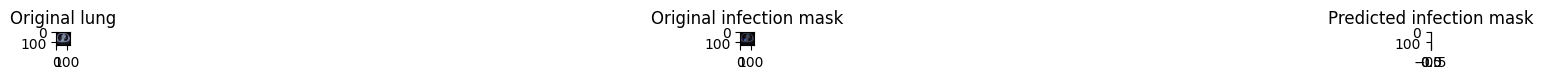

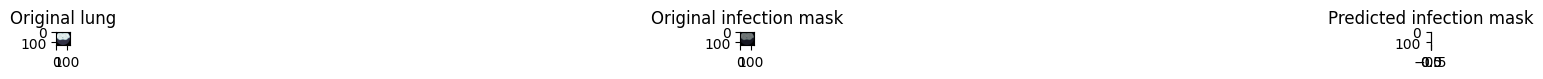

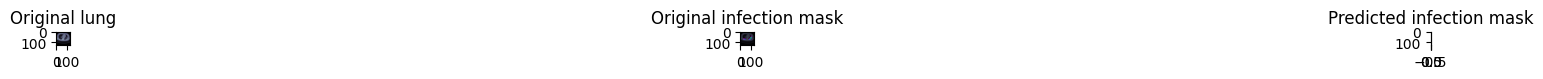

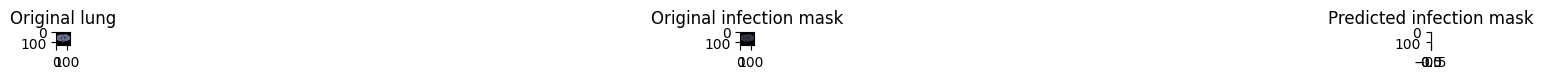

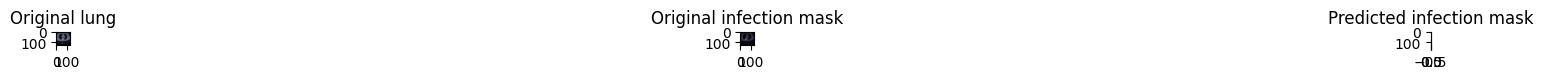

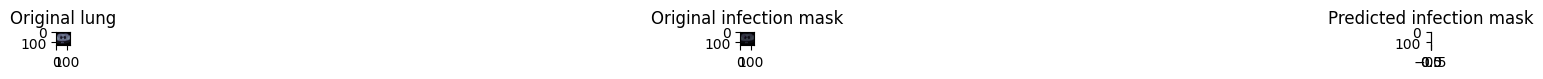

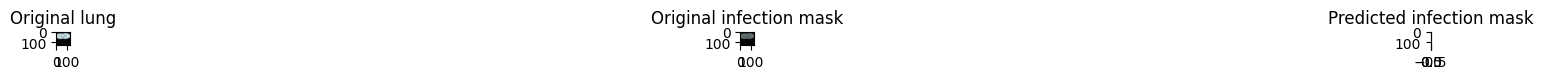

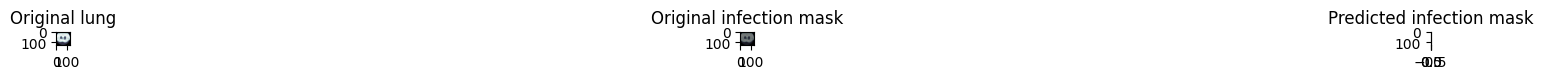

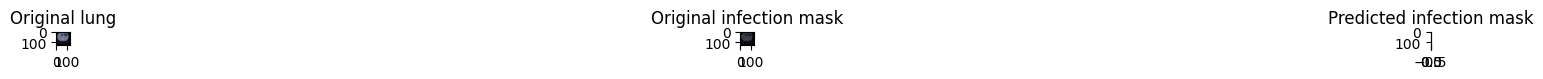

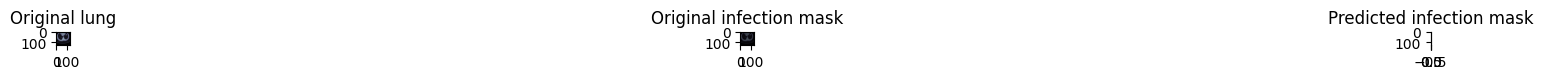

Error in callback <function flush_figures at 0x0000017C80481EE0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
with tf.device(device):
    
    # predicted = model.predict(lung_test)
    # Visualize results
    fig = plt.figure(figsize=(25, 75))
    plt.subplot(num, 3, 1)
    plt.imshow(lung_test[img_num], cmap='bone')
    plt.title('Original lung')

    plt.subplot(num, 3, 2)
    plt.imshow(lung_test[img_num], cmap='bone')
    plt.imshow(infect_test[img_num][..., 0], alpha=0.5, cmap="nipy_spectral")
    plt.title('Original infection mask')

    plt.subplot(num, 3, 3)
    plt.imshow(lung_test[img_num], cmap='bone')
    plt.imshow(predicted[img_num][img_num, ...], alpha=0.5, cmap="nipy_spectral")
    plt.title('Predicted infection mask')

In [ ]:
# Plot Jaccard Index (MeanIoU)
plt.plot(results.history['mean_io_u'])
plt.plot(results.history['val_mean_io_u'])
plt.title('MeanIoU (Jaccard Index) vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MeanIoU (Jaccard Index)')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

NameError: name 'results' is not defined

In [ ]:
model.save_weights("UNetSquared_wt.h5")